# **Assignment #2 - PySpark Solutions**
#### **Mining Large Scale Datasets 2024/2025**
#### Maria Rafaela Abrunhosa 107558

## Context and Motivation
For each of the following exercises, we will implement the solutions using pyspark. We will start by using small samples of the dataset for developing and initial testing, and then run on the full data.
This assignment is composed by three exercises, exercise A, B and C.

### Exercise A - People You Might Know (Friendship recommendations)

In this exercise, you're going to implement a friend recommendation algorithm based on mutual friends, using data from the LiveJournal social network. The input is a file where each line has the ID of a user and a list of their friends. The algorithm should recommend up to 10 users with whom the person is not friends, but who have more friends in common with them. The output should show, for each user, the recommended IDs sorted by the number of friends in common (and, in the event of a tie, in numerical order). It's important to handle cases with few or no friends well. The aim is to apply join, flatMap, groupBy and other PySpark operations to find these recommendations in a distributed way.

### Exercise B - Discovering Associations between Medical Conditions (A-Priori)

Here you'll use the A-Priori algorithm to discover frequent associations between patients' medical conditions from a conditions.csv.gz file. First, you have to transform the data to group the conditions by patient, as if it were a ‘shopping basket’ of diseases. Then you apply the A-Priori algorithm with a minimum support of 1000 to find frequent combinations of 2 and 3 conditions. You'll also generate association rules of the type (X) → Y and (X, Y) → Z, with standardised lift ≥ 0.2, and save the rules with their values (lift, confidence, interest) in a file. The aim is to discover relevant clinical patterns on a large scale.

### Exercise C - Grouping songs with BFR

In this exercise, you'll apply the BFR (Bradley-Fayyad-Reina) algorithm to group songs based on their acoustic characteristics. You start by using hierarchical clustering on a small subset (8000 songs) to test various values of k (between 8 and 16) and calculate cluster metrics (radius, diameter, density). Then you choose the best k and apply the BFR algorithm to the entire dataset (over 100,000 tracks). Finally, you use the metadata from the tracks.csv file to describe the clusters according to the predominant musical genres. The idea is to scale clustering efficiently and relate clusters to musical styles.

### PySpark
PySpark is the Python API for Apache Spark, an open-source, distributed computing system used for big data processing and analytics. It allows Python developers to write scalable, parallelized data transformations and machine learning workflows.

#### Common Utilities of PySpark
PySpark is useful for:
-  handling huge datasets: processing data that does not fit in memory.
- data preprocessing: clean, filter and aggregate large datasets efficiently.
- SQL on big data: use Spark SQL to query distributed data like a traditional database.
- streaming: Process real-time data streams using Spark Streaming.

#### Imports

In [1]:
# imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, collect_set
from pyspark.sql import Row
from pyspark.sql.types import IntegerType

import pandas as pd
from itertools import combinations
from collections import namedtuple

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
import numpy as np

import re
from collections import defaultdict

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

### Exercise A
Write a program that implements a simple “People You Might Know” social network friendship recommendation algorithm. The key idea is that if two people have a lot of mutual friends, then the system should recommend that they connect with each other.
Data:
- Associated data file is ``soc-LiveJournal1Adj.txt`` found in the shared folder.
- The file contains the adjacency list and has multiple lines in the following format:
    - ``User > TAB > Friends``
    - ``User`` is a unique integer ID corresponding to a unique user and
    - ``Friends`` is a comma separated list of unique IDs corresponding to the friends of the user with the unique ID ``User``.

Note that the friendships are mutual: if A is friend with B then B is also friend with A.

Implement a simple algorithm such that, for each user U, the algorithm recommends N = 10 users who are not already friends with U, but have the most number of mutual friends in common with U.
The output should contain one line per user in the following format:

``User > TAB > Recommendations`` where ``User`` is a unique ID corresponding to a user and ``Recommendations`` is a comma separated list of unique IDs corresponding to the algorithm’s recommendation of people that ``User`` might know, ordered in decreasing number of mutual friends.

Even if a user has less than 10 second-degree friends, output all of them in decreasing order of the number of mutual friends. If a user has no friends, you can provide an empty list of recommendations. If there are recommended users with the same number of mutual friends, then output those user IDs in numerically ascending order.

In [2]:
# some useful functions

def line_to_id_list(line):
    """
    The line: ``0    1,2,3,4`` will get parsed to:
    ``(0, [1, 2, 3, 4])``

    That is, a python tuple where the first element is the user id and the second element is a list of his friends

    :param line: str
    :return: tuple(id, list(friends_ids)), the parsed line
    """
    split = line.split()
    user_id = split[0]

    if len(split) != 1:
        friends = list(map(lambda x: int(x), split[1].split(',')))

    return user_id, friends

def check_mutual_connection(friendsList):
    """
   The value ``(0, [1, 2, 3])`` will get mapped to::

        [
            ((0,1), 0),
            ((0,2), 0),
            ((0,3), 0),
            ((1,2), 1),
            ((1,3), 1),
            ((2,3), 1)
        ]

    We convert the friends list a list of to a all connection information list.
    We will have two types of tuples, a tuple of users that are already friends ``((0,1), 0)``, user 0 and user 1 are friends, and a tuple
    of users that have a mutual friend, ``((1,2), 1)``.
    The mutual friends tuple indicate that the users share a single mutual friend.

    It is important to notice that, every user that is in the list of friends of a specific user, are users with a mutual friend.
    
    :param friendsList: the list of friends for user
    :return: list(tuple(tuple(int, int), int)) of connections between users, friends or share a mutual friend
    """
    connections = []
    user_id = int(friendsList[0])
    friends = friendsList[1]

    # create connections between a user and its friends, connection is 0 because they are friends
    for friend_id in friends:
        # if user_id > friend_id:
        #     connection = (friend_id, user_id)
        # else:
        # tuple(sorted((user_id, friend_id)))
        
        connection = tuple(sorted((user_id, friend_id)))
        connections.append((connection, 0))

    # create connections between user's friends, connection is 1 because they have a mutual friend
    for friends_pair in combinations(friends, 2):
        connection = tuple(sorted(friends_pair))
    
        connections.append((connection, 1))

    return connections

In [ ]:
# create a spark session
sparkA = SparkSession.builder.appName("People You Might Know").getOrCreate()

# create a dataframe using soc-LiveJournal1Adj.txt
friends = sparkA.read.text("data/friends_smallset.txt").rdd.map(lambda row: row[0])
friends.take(5)

friendId_list = friends.map(line_to_id_list)
friendId_list.take(5)

usersConnections = friendId_list.flatMap(check_mutual_connection)
usersConnections.take(25)

# filter existing friendship
mutual_friend_counts = usersConnections.groupByKey() \
    .filter(lambda edge: 0 not in edge[1]) \
    .map(lambda edge: (edge[0], sum(edge[1])))
mutual_friend_counts.take(25)

# group the connections by the key (tuple ids) and count mutuals
mutualFriendsCount = mutual_friend_counts.reduceByKey(lambda a,b: a+b)
mutualFriendsCount.take(25)

# emit both (user, (possible_, mutuals)) and (friend, (user, mutuals))
recommendationsDuplicate = mutualFriendsCount.flatMap(lambda x: [
    (x[0][0], (x[0][1], x[1])),
    (x[0][1], (x[0][0], x[1]))
])
recommendationsDuplicate.take(25)

# group recomendations by key, to get (user_id, Iterable[(recommended_user_id, mutual_friends_count)]) with a list of recommended users
recommendationsByKey = recommendationsDuplicate.groupByKey()

# get top 10 recommendations and sort by descending order of mutual friends count and ascending order of user id
recommendations = recommendationsByKey.mapValues(lambda recommendation: sorted(list(recommendation), key=lambda k: (-k[1], k[0]))[:10])
recommendations.take(15)

# get the top 10 recommended friends
# top10 = recommendations.take(11)
# top10

# <user_id> <TAB> <recommended_user_id_1>,<recommended_user_id_2>,...

final_recommendations = recommendations.mapValues(
    lambda recs: ",".join(str(user) for user, _ in recs[:10])
)

# format the recommendations to <User> <TAB> <Recommendations>
formatted_recommendations = final_recommendations.map(
    lambda x: f"{x[0]}\t{x[1]}"
)

formatted_recommendations.take(10)

# store on the text file recommendations_output.txt
with open("output/recommendations_output.txt", "w", encoding="utf-8") as f:
    for line in formatted_recommendations.collect():
        f.write(line + "\n")
    
# final_recommendations = recommendations.mapValues(
#     lambda recs: ",".join(str(user) for user, _ in recs[:10])
# )

# final_recommendations.take(10)
# final_recommendations.saveAsTextFile("output_recommendations")

# stop the spark session
sparkA.stop()

### Exercise B

The file ‘conditions.csv.gz’ (available on the shared folder) lists conditions for a large set of patients. Our purpose is to find associations between conditions.
The file contains the following fields, with multiple non-consecutive entries for each patient: START,STOP,PATIENT,ENCOUNTER,CODE,DESCRIPTION.
- PATIENT is the patient identifier
- CODE is a condition identifier
- DESCRIPTION is the name of the condition

You may prefer to reorganize the data before applying the algorithms.

Implement the A-Priori algorithm in pyspark:
1. Apply the implemented algorithm with a support threshold of 1000 to obtain the frequent itemsets for sizes k = 2 and k = 3. Include in your results the lists of the 10 most frequent itemsets for k = 2 and k = 3.
2. Obtain associations between conditions by extracting rules ofthe forms (X) →Y and (X,Y) → Z, with minimum standardized lift of 0.2. Write the rules to a text file, showing the standardized lift, lift, confidence and interest values, sorted by standardized lift

In [ ]:
# initialization of variables
sparkB = SparkSession.builder.appName("Apriori Algorithm - Patients Conditions").getOrCreate()

conditions = sparkB.read.option("header", True).csv("data/conditions.csv.gz")
conditions.show(25)

+----------+----------+--------------------+--------------------+---------+--------------------+
|     START|      STOP|             PATIENT|           ENCOUNTER|     CODE|         DESCRIPTION|
+----------+----------+--------------------+--------------------+---------+--------------------+
|2017-01-14|2017-03-30|09e4e8cb-29c2-4ef...|88e540ab-a7d7-47d...| 65363002|        Otitis media|
|2012-09-15|2012-09-16|b0a03e8c-8d0f-424...|e89414dc-d0c6-478...|241929008|Acute allergic re...|
|2018-06-17|2018-06-24|09e4e8cb-29c2-4ef...|c14325b0-f7ec-431...|444814009|Viral sinusitis (...|
|2019-04-19|2019-09-26|09e4e8cb-29c2-4ef...|71af18ee-3157-408...| 65363002|        Otitis media|
|2019-04-27|2019-05-18|09e4e8cb-29c2-4ef...|411d4eae-72d1-478...|444814009|Viral sinusitis (...|
|2019-06-03|2019-08-02|09e4e8cb-29c2-4ef...|667a94d9-6aa1-4b6...| 33737001|     Fracture of rib|
|2014-11-09|2014-11-30|b0a03e8c-8d0f-424...|53431016-43c6-46b...|444814009|Viral sinusitis (...|
|2015-01-04|2015-01-18|b0a03e8

Each transaction is a set of ‘items’. In this case:
- An ‘item’ is a diagnosis (condition), e.g. Otitis media (or the code 65363002);
- A ‘transaction’ is the set of all the conditions assigned to a patient.

So, for each patient, we want to know all the conditions (codes or descriptions) for which they were diagnosed. These sets will be used to look for frequent patterns between patients.

| PATIENT | CODE | DESCRIPTION |
| ------- | ---- | ----------- |
| 09e4e8cb-29c2-4ef4-86c0-a6ff0ba25d2a | 65363002 | Otitis media |
| 09e4e8cb-29c2-4ef4-86c0-a6ff0ba25d2a | 444814009 | Viral sinusitis |
| b0a03e8c-8d0f-4242-9548-40f4d294eba8 | 241929008 | Allergic reaction |
| b0a03e8c-8d0f-4242-9548-40f4d294eba8 | 444814009 | Viral sinusitis |
| 5420ae87-24c8-4ed4-ad14-041d15aadae9 | 446096008 | Perennial allergic rhinitis |

transactions = [

   ["65363002", "444814009"],   # P1

   ["241929008", "444814009"],   # P2

   ["446096008"]    # P3

]

#### Reorganize the data before applying the algorithm

In [46]:
# group conditions by patients
patients = conditions.groupBy("PATIENT").agg(collect_set("CODE").alias("CONDITIONS")) # using CODE can be more efficient, DESCRIPTION can be used and it can show more legible results
patients.show(truncate=False)

total_baskets = patients.count()
print(f"Total number of baskets (patients): {total_baskets}")

+------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|PATIENT                             |CONDITIONS                                                                                                                                                                        |
+------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|000134b3-b39d-47c1-8bb5-772578543b19|[271737000, 201834006, 40055000, 10509002, 19169002, 444814009, 15777000, 55822004]                                                                                               |
|000217d4-7ed6-4b9b-9987-df487a9ed712|[70704007, 65363002]                                                                      

Total number of baskets (patients): 1157578


In [76]:
# group conditions names by code
conditions_name = conditions.groupBy("DESCRIPTION").agg(collect_set("CODE").alias("CODE"))
conditions_name.show(truncate=False)

+----------------------------------------------------+----------------+
|DESCRIPTION                                         |CODE            |
+----------------------------------------------------+----------------+
|Acute Cholecystitis                                 |[65275009]      |
|Acute allergic reaction                             |[241929008]     |
|Acute bacterial sinusitis (disorder)                |[75498004]      |
|Acute bronchitis (disorder)                         |[10509002]      |
|Acute respiratory failure (disorder)                |[65710008]      |
|Acute viral pharyngitis (disorder)                  |[195662009]     |
|Alcoholism                                          |[7200002]       |
|Alzheimer's disease (disorder)                      |[26929004]      |
|Anemia (disorder)                                   |[271737000]     |
|Antepartum eclampsia                                |[198992004]     |
|Appendicitis                                        |[74400008]

**Initialize some variables important for the exercise**

In [48]:
# initialize variables
min_support = 1000
min_std_lift = 0.2

#### A-Priori Algorithm

Support threshold of 1000.

In [49]:
# a-priori algorithm in pyspark

# convert rdd to lists
conditions_rdd = patients.select("CONDITIONS").rdd.map(lambda row: row[0])

# --------- 1-itemsets ----------
# count occurencies of each item
item_counts = conditions_rdd.flatMap(lambda x: x).map(lambda item: (item, 1)).reduceByKey(lambda a, b: a + b)

frequent1 = item_counts.filter(lambda x: x[1] >= min_support).collectAsMap()

# sorted_frequent1 = sorted(frequent1.items(), key=lambda x: (len(str(x[0])), x[0]))
# formatted_items = [str(item) for item, count in sorted_frequent1]
# sorted_frequent1_str = ', '.join(formatted_items)

print("Frequent 1-itemsets:", frequent1)

# --------- 2-itemsets ----------
# generates items pairs
pair_counts = conditions_rdd.flatMap(lambda x: [tuple(sorted(pair)) for pair in combinations(x, 2)]).map(lambda pair: (pair, 1)).reduceByKey(lambda a, b: a + b)

frequent2 = pair_counts.filter(lambda x: x[1] >= min_support).takeOrdered(10, key=lambda x: -x[1])
frequent2_dict = dict(frequent2)
print("Top 10 Frequent 2-itemsets:", frequent2)

# --------- 3-itemsets ----------
# generates sets of 3 items
triplet_counts = conditions_rdd.filter(lambda x: len(x) >= 3).flatMap(lambda x: [tuple(sorted(triplet)) for triplet in combinations(x, 3)]).map(lambda triplet: (triplet, 1)).reduceByKey(lambda a, b: a + b)

frequent3 = triplet_counts.filter(lambda x: x[1] >= min_support).takeOrdered(10, key=lambda x: -x[1])
print("Top 10 Frequent 3-itemsets:", frequent3)

Frequent 1-itemsets: {'90781000119102': 4861, '237602007': 74395, '403190006': 26363, '301011002': 29981, '283385000': 34720, '1551000119108': 11705, '230265002': 7134, '90560007': 8865, '262574004': 7629, '162864005': 365567, '446096008': 31095, '713197008': 25903, '368581000119106': 26779, '38822007': 20349, '55680006': 53382, '40275004': 6160, '198992004': 22738, '233604007': 11175, '126906006': 28954, '444448004': 8650, '403192003': 1945, '44465007': 118138, '26929004': 34746, '53741008': 68517, '47693006': 16103, '196416002': 55105, '307731004': 17220, '398254007': 22959, '283371005': 34764, '162573006': 15017, '449868002': 13738, '109838007': 8153, '239720000': 5484, '314994000': 4802, '6072007': 4422, '94260004': 2049, '195967001': 1814, '70704007': 52207, '39848009': 54950, '16114001': 34085, '431856006': 4714, '431855005': 32321, '92691004': 26353, '271737000': 355372, '444814009': 751940, '127013003': 34609, '82423001': 54974, '33737001': 17228, '444470001': 6190, '83664006':

Top 10 Frequent 2-itemsets: [(('195662009', '444814009'), 343651), (('10509002', '444814009'), 302516), (('15777000', '271737000'), 289176), (('162864005', '444814009'), 243812), (('271737000', '444814009'), 236847), (('15777000', '444814009'), 236320), (('10509002', '195662009'), 211065), (('444814009', '59621000'), 203450), (('162864005', '195662009'), 167438), (('40055000', '444814009'), 165530)]


Top 10 Frequent 3-itemsets: [(('15777000', '271737000', '444814009'), 192819), (('10509002', '195662009', '444814009'), 139174), (('15777000', '195662009', '271737000'), 132583), (('10509002', '15777000', '271737000'), 115510), (('162864005', '195662009', '444814009'), 111860), (('195662009', '271737000', '444814009'), 108560), (('15777000', '195662009', '444814009'), 108083), (('15777000', '271737000', '59621000'), 99818), (('10509002', '162864005', '444814009'), 97384), (('10509002', '271737000', '444814009'), 94793)]


In [50]:
# -------- top frequent 2 and 3 items with conditions names -------
unique_conditions = conditions.dropDuplicates(["CODE"])

frequent2_rdd = sparkB.sparkContext.parallelize(frequent2).map(
    lambda x: Row(item1=x[0][0], item2=x[0][1], count=x[1])
)

frequent2_df = sparkB.createDataFrame(frequent2_rdd)

frequent2_named = frequent2_df \
    .join(unique_conditions.selectExpr("CODE as item1", "DESCRIPTION as name1"), on="item1") \
    .join(unique_conditions.selectExpr("CODE as item2", "DESCRIPTION as name2"), on="item2")

frequent2_named.select("item1", "name1", "item2", "name2", "count").show(truncate=False)

frequent3_rdd = sparkB.sparkContext.parallelize(frequent3).map(
    lambda x: Row(item1=x[0][0], item2=x[0][1], item3=x[0][2], count=x[1])
)

frequent3_df = sparkB.createDataFrame(frequent3_rdd)

frequent3_named = frequent3_df \
    .join(unique_conditions.selectExpr("CODE as item1", "DESCRIPTION as name1"), on="item1") \
    .join(unique_conditions.selectExpr("CODE as item2", "DESCRIPTION as name2"), on="item2") \
    .join(unique_conditions.selectExpr("CODE as item3", "DESCRIPTION as name3"), on="item3")

frequent3_named.select("item1", "name1", "item2", "name2", "item3", "name3", "count").show(truncate=False)

+---------+---------------------------------------+---------+----------------------------------+------+
|item1    |name1                                  |item2    |name2                             |count |
+---------+---------------------------------------+---------+----------------------------------+------+
|195662009|Acute viral pharyngitis (disorder)     |444814009|Viral sinusitis (disorder)        |343651|
|10509002 |Acute bronchitis (disorder)            |444814009|Viral sinusitis (disorder)        |302516|
|15777000 |Prediabetes                            |271737000|Anemia (disorder)                 |289176|
|162864005|Body mass index 30+ - obesity (finding)|444814009|Viral sinusitis (disorder)        |243812|
|271737000|Anemia (disorder)                      |444814009|Viral sinusitis (disorder)        |236847|
|15777000 |Prediabetes                            |444814009|Viral sinusitis (disorder)        |236320|
|10509002 |Acute bronchitis (disorder)            |195662009|Acu

+---------+---------------------------------------+---------+---------------------------------------+---------+--------------------------+------+
|item1    |name1                                  |item2    |name2                                  |item3    |name3                     |count |
+---------+---------------------------------------+---------+---------------------------------------+---------+--------------------------+------+
|15777000 |Prediabetes                            |271737000|Anemia (disorder)                      |444814009|Viral sinusitis (disorder)|192819|
|10509002 |Acute bronchitis (disorder)            |195662009|Acute viral pharyngitis (disorder)     |444814009|Viral sinusitis (disorder)|139174|
|15777000 |Prediabetes                            |195662009|Acute viral pharyngitis (disorder)     |271737000|Anemia (disorder)         |132583|
|10509002 |Acute bronchitis (disorder)            |15777000 |Prediabetes                            |271737000|Anemia (disor

#### Associations between conditions
Extract rules of the forms:
- (X) → Y
- (X,Y) → Z

Minimum standardized lift of 0.2.\
We want to get the standardized lift, lift, confidence and interest values, sorted by standardized lift.

| Metric | Formula |
| ------ | ------- |
| Confidence | conf(X→Y) = suport(X, Y) / suport(X) |
| Lift | lift(X→Y) = conf(X→Y) / suport(Y) |
| Interest | interest(X→Y) = suport(X, Y) − (suport(X) * suport(Y)) |
| Standardized Lift	| standardLift(X→Y) = (lift - min) / (max - min), where min = max(pa + pb - 1, 1 / total_baskets) / (pa * pb) and max = 1 / max(pa, pb) |

<br>

- **Confidence:** This measures the likelihood of finding Y given that X is present. It's computed as the ratio of suport(X, Y) (the support for both X and Y together) over the support of X.

- **Lift:** This measures how much more likely Y is to occur with X than without it. Lift is computed by dividing the confidence of X → Y by the support of Y.

- **Interest:** This measures the difference between the observed co-occurrence and the expected co-occurrence of X and Y. It is computed as suport(X, Y) minus the expected support suport(X) * suport(Y).

- **Standardized Lift:** Standardized lift takes into account the possible values of lift based on the support of X and Y. It normalizes the lift value so it falls between a minimum and maximum range, using the formulas provided for min and max.

**Confidence Formulas**

In [51]:
def confidencePairs(a, b, count):
    supportFirst = frequent1[a]

    if supportFirst != 0:
        confidence = round(count / supportFirst, 4)
    else:
        confidence = 0

    return confidence

def confidenceTriplets(pair, c, count):
    supportFirst = frequent2_dict.get(pair, 0) # deal with key error

    if supportFirst != 0:
        confidence = round(count / supportFirst, 4)
    else:
        confidence = 0

    return confidence

In [52]:
# testing
frequent2_dict.get(('195662009', '444814009'), 0)

343651

**Lift Formulas**

In [53]:
# lift calculation
def liftPairs(a, b, count, total_baskets):

    lift = confidencePairs(a, b, count) / (frequent1[b] / total_baskets)
    return lift

def liftTriplets(pair, c, count, total_baskets):
    
    lift = confidenceTriplets(pair, c, count) / (frequent1[c] / total_baskets)
    return lift

**Interest Formulas**

In [54]:
# interest calculation
def interestPairs(a, b, count, total_baskets):

    interest = confidencePairs(a, b, count) - (frequent1[b] / total_baskets)
    return interest

def interestTriplets(pair, c, count, total_baskets):

    interest = confidenceTriplets(pair, c, count) - (frequent1[c] / total_baskets)
    return interest

**Standardized Lift Formulas**

In [55]:
# standard lift calculation
def standardizedLiftPairs(a, b, count, total_baskets):
    pa = frequent1[a] / total_baskets
    pb = frequent1[b] / total_baskets

    lift = liftPairs(a, b, count, total_baskets)

    if pa != 0 and pb != 0:
        max_lift = 1 / max(pa, pb)
        min_lift = max(pa + pb - 1, 1 / total_baskets) / (pa * pb) # if pa * pb > 0 else 0
        std_lift = (lift - min_lift) / (max_lift - min_lift) if (max_lift - min_lift) != 0 else 0
    
    else:
        std_lift =  0

    return std_lift

def standardizedLiftTriplets(pair, c, count, total_baskets):
    pab = frequent2_dict.get(pair, 0) / total_baskets
    pc = frequent1[c] / total_baskets

    lift = liftTriplets(pair, c, count, total_baskets)

    if pab != 0 and pc != 0:
        max_lift = 1 / max(pab, pc)
        min_lift = max(pab + pc - 1, 1 / total_baskets) / (pab * pc)
        std_lift = (lift - min_lift) / (max_lift - min_lift) if (max_lift - min_lift) != 0 else 0

    else:
        std_lift = 0

    return std_lift

**Metrics for pairs and triplets**

In [56]:
metricsPair = namedtuple('MetricsPair', ['a', 'b', 'std_lift', 'lift', 'confidence', 'interest'])
metricsTriplet = namedtuple('MetricsTriplet', ['pair', 'c', 'std_lift', 'lift', 'confidence', 'interest'])

def metricsPairs(pair, total_baskets):
    a, b = pair[0]
    count = pair[1]

    confidence = confidencePairs(a, b, count)
    lift = liftPairs(a, b, count, total_baskets)
    interest = interestPairs(a, b, count, total_baskets)
    std_lift = standardizedLiftPairs(a, b, count, total_baskets)

    return metricsPair(
        a=a,
        b=b,
        std_lift=std_lift,
        lift=lift,
        confidence=confidence,
        interest=interest
    )

def metricsTriplets(triplet, total_baskets):
    pair = triplet[0]
    # print("pair:", pair)
    c = triplet[1]
    count = triplet[2]

    confidence = confidenceTriplets(pair, c, count)
    lift = liftTriplets(pair, c, count, total_baskets)
    interest = interestTriplets(pair, c, count, total_baskets)
    std_lift = standardizedLiftTriplets(pair, c, count, total_baskets)

    return metricsTriplet(
        pair=pair,
        c=c,
        std_lift=std_lift,
        lift=lift,
        confidence=confidence,
        interest=interest
    )

**Get rules variations**

In [57]:
# create rules with variations
def rulesPairs(pair):
    a, b = pair[0]
    count = pair[1]
    return [
        f"{a} -> {b}: {count}", # maybe remove count
        f"{b} -> {a}: {count}"
    ]

def rulesTriplets(triple_count):
    a, b, c = triple_count[0]
    count = triple_count[1]
    return [
        f"({a}, {b}) -> {c}: {count}",
        f"({a}, {c}) -> {b}: {count}",
        f"({b}, {c}) -> {a}: {count}"
    ]

def parsePairRuleString(rule_str):
    """
    transforms 'a -> b: 12345' in ((a, b), count)
    """
    parts = rule_str.split(':')
    rule = parts[0].strip()
    count = int(parts[1].strip())
    
    a, b = rule.split('->')
    a = a.strip()
    b = b.strip()
    
    return ((a, b), count)

def parseTripletRuleString(rule_str):
    """
    transforms '(a, b) -> c: 12345' in ((a, b), c, count)
    """
    parts = rule_str.split(':')
    rule = parts[0].strip()
    count = int(parts[1].strip())
    
    ab, c = rule.split('->')
    c = c.strip()
    
    ab = ab.strip()[1:-1] # remove '(' and ')'
    a, b = [x.strip() for x in ab.split(',')]
    
    return ((a, b), c, count)


**Get candidate rules**

All rules that we got from the most frequent sets of items, not filtered.

In [58]:
# candidate rules
frequent2_rdd = sparkB.sparkContext.parallelize(frequent2)
candidate_double_rules = frequent2_rdd.flatMap(rulesPairs)

for c2 in candidate_double_rules.take(25):
    print(c2)

frequent3_rdd = sparkB.sparkContext.parallelize(frequent3)
candidate_triple_rules = frequent3_rdd.flatMap(rulesTriplets)

for c3 in candidate_triple_rules.take(25):
    print(c3)

# candidate_triple_rules.take(10)

195662009 -> 444814009: 343651
444814009 -> 195662009: 343651
10509002 -> 444814009: 302516
444814009 -> 10509002: 302516
15777000 -> 271737000: 289176
271737000 -> 15777000: 289176
162864005 -> 444814009: 243812
444814009 -> 162864005: 243812
271737000 -> 444814009: 236847
444814009 -> 271737000: 236847
15777000 -> 444814009: 236320
444814009 -> 15777000: 236320
10509002 -> 195662009: 211065
195662009 -> 10509002: 211065
444814009 -> 59621000: 203450
59621000 -> 444814009: 203450
162864005 -> 195662009: 167438
195662009 -> 162864005: 167438
40055000 -> 444814009: 165530
444814009 -> 40055000: 165530
(15777000, 271737000) -> 444814009: 192819
(15777000, 444814009) -> 271737000: 192819
(271737000, 444814009) -> 15777000: 192819
(10509002, 195662009) -> 444814009: 139174
(10509002, 444814009) -> 195662009: 139174
(195662009, 444814009) -> 10509002: 139174
(15777000, 195662009) -> 271737000: 132583
(15777000, 271737000) -> 195662009: 132583
(195662009, 271737000) -> 15777000: 132583
(1050

**Calculate the metrics for each rule and each variation**

We calculate the confidence, the lift, the interest and the standardized lift.

In [59]:
# get metrics for each rule
parsed_pairs = candidate_double_rules.map(lambda rule: parsePairRuleString(rule))
metrics_pairs = parsed_pairs.map(lambda pair: metricsPairs(pair, total_baskets))

for m2 in metrics_pairs.take(25):
    print(m2)

parsed_triplets = candidate_triple_rules.map(lambda rule: parseTripletRuleString(rule))
metrics_triplets = parsed_triplets.map(lambda triplet: metricsTriplets(triplet, total_baskets))

for m3 in metrics_triplets.take(25):
    print(m3)

MetricsPair(a='195662009', b='444814009', std_lift=0.5537431404355608, lift=1.0083432055749129, confidence=0.655, interest=0.005419582956828872)
MetricsPair(a='444814009', b='195662009', std_lift=0.5536527149823244, lift=1.008235585829401, confidence=0.457, interest=0.003732919941464019)
MetricsPair(a='10509002', b='444814009', std_lift=0.6080618001765119, lift=1.0091129332127564, confidence=0.6555, interest=0.005919582956828817)
MetricsPair(a='444814009', b='10509002', std_lift=0.6080506806561513, lift=1.009097887084367, confidence=0.4023, interest=0.0036270811988479146)
MetricsPair(a='15777000', b='271737000', std_lift=0.8161994812510938, lift=2.6586651835259953, confidence=0.8162, interest=0.5092038407779)
MetricsPair(a='271737000', b='15777000', std_lift=0.8161269280920314, lift=2.658428851727982, confidence=0.8137, interest=0.5076169541922877)
MetricsPair(a='162864005', b='444814009', std_lift=0.6668990888102285, lift=1.026662723355587, confidence=0.6669, interest=0.01731958295682

**Rules filtration**

We extract the rules that have a minimum standardized lift of 0.2.

In [66]:
# filter the rules and extract the ones with minimum standardized lift of 0.2

filtered_pairs = metrics_pairs.filter(lambda metrics: metrics.std_lift >= min_std_lift)

# sort the filtered pair by descending order of standardized lift and ascending order of a, b
sorted_filtered_pairs = filtered_pairs.sortBy(lambda metrics: metrics.std_lift, ascending=False)

sorted_pairs_values = sorted_filtered_pairs.map(lambda item: (item.a, item.b, item.std_lift, item.lift, item.confidence, item.interest)).collect()
for a, b, std_lift, lift, confidence, interest in sorted_pairs_values:
    print(f"Rule: ({a}) -> {b}")
    print(f"  Standardized Lift: {round(std_lift, 4)}")
    print(f"  Lift: {round(lift, 4)}")
    print(f"  Confidence: {round(confidence, 4)}")
    print(f"  Interest: {round(interest, 4)}\n")

filtered_triplets = metrics_triplets.filter(lambda metrics: metrics.std_lift >= min_std_lift)

# sort the filtered triplet by descending order of standardized lift and ascending order of a, b
sorted_filtered_triplets = filtered_triplets.sortBy(lambda metrics: metrics.std_lift, ascending=False)

sorted_triplets_values = sorted_filtered_triplets.map(lambda item: (item.pair, item.c, item.std_lift, item.lift, item.confidence, item.interest)).collect()
for pair, c, std_lift, lift, confidence, interest in sorted_triplets_values:
    print(f"Rule: ({pair[0]}, {pair[1]}) -> {c}")
    print(f"  Standardized Lift: {round(std_lift, 4)}")
    print(f"  Lift: {round(lift, 4)}")
    print(f"  Confidence: {round(confidence, 4)}")
    print(f"  Interest: {round(interest, 4)}\n")

# format strings specifically rules to store in a text file
sorted_pairs_values = sorted_filtered_pairs.map(
    lambda item: f"({item.a}) -> {item.b}\n"
                 f"  Standardized Lift: {round(item.std_lift, 4)}\n"
                 f"  Lift: {round(item.lift, 4)}\n"
                 f"  Confidence: {round(item.confidence, 4)}\n"
                 f"  Interest: {round(item.interest, 4)}\n"
).collect()

sorted_triplets_values = sorted_filtered_triplets.map(
    lambda item: f"({item.pair[0]}, {item.pair[1]}) -> {item.c}\n"
                 f"  Standardized Lift: {round(item.std_lift, 4)}\n"
                 f"  Lift: {round(item.lift, 4)}\n"
                 f"  Confidence: {round(item.confidence, 4)}\n"
                 f"  Interest: {round(item.interest, 4)}\n"
).collect()

Rule: (15777000) -> 271737000
  Standardized Lift: 0.8162
  Lift: 2.6587
  Confidence: 0.8162
  Interest: 0.5092

Rule: (271737000) -> 15777000
  Standardized Lift: 0.8161
  Lift: 2.6584
  Confidence: 0.8137
  Interest: 0.5076

Rule: (444814009) -> 15777000
  Standardized Lift: 0.667
  Lift: 1.0268
  Confidence: 0.3143
  Interest: 0.0082

Rule: (15777000) -> 444814009
  Standardized Lift: 0.667
  Lift: 1.0268
  Confidence: 0.667
  Interest: 0.0174

Rule: (162864005) -> 444814009
  Standardized Lift: 0.6669
  Lift: 1.0267
  Confidence: 0.6669
  Interest: 0.0173

Rule: (444814009) -> 162864005
  Standardized Lift: 0.6669
  Lift: 1.0266
  Confidence: 0.3242
  Interest: 0.0084

Rule: (444814009) -> 59621000
  Standardized Lift: 0.6668
  Lift: 1.0266
  Confidence: 0.2706
  Interest: 0.007

Rule: (59621000) -> 444814009
  Standardized Lift: 0.6668
  Lift: 1.0265
  Confidence: 0.6668
  Interest: 0.0172

Rule: (444814009) -> 271737000
  Standardized Lift: 0.6665
  Lift: 1.0261
  Confidence: 0.

**Store the rules extracted on a text file**

Write the rules of the forms (X) → Y and (X, Y) → Z to a text file, showing the standardized lift, lift, confidence and interest values, sorted by standardized lift.

In [ ]:
rules = sorted_pairs_values + sorted_triplets_values

for rule in rules:
    print(rule)

# store on the text file association_rules_output.txt
with open("output/association_rules_output.txt", "w", encoding="utf-8") as f:
    for line in rules:
        f.write(line + "\n")

(15777000) -> 271737000
  Standardized Lift: 0.8162
  Lift: 2.6587
  Confidence: 0.8162
  Interest: 0.5092

(271737000) -> 15777000
  Standardized Lift: 0.8161
  Lift: 2.6584
  Confidence: 0.8137
  Interest: 0.5076

(444814009) -> 15777000
  Standardized Lift: 0.667
  Lift: 1.0268
  Confidence: 0.3143
  Interest: 0.0082

(15777000) -> 444814009
  Standardized Lift: 0.667
  Lift: 1.0268
  Confidence: 0.667
  Interest: 0.0174

(162864005) -> 444814009
  Standardized Lift: 0.6669
  Lift: 1.0267
  Confidence: 0.6669
  Interest: 0.0173

(444814009) -> 162864005
  Standardized Lift: 0.6669
  Lift: 1.0266
  Confidence: 0.3242
  Interest: 0.0084

(444814009) -> 59621000
  Standardized Lift: 0.6668
  Lift: 1.0266
  Confidence: 0.2706
  Interest: 0.007

(59621000) -> 444814009
  Standardized Lift: 0.6668
  Lift: 1.0265
  Confidence: 0.6668
  Interest: 0.0172

(444814009) -> 271737000
  Standardized Lift: 0.6665
  Lift: 1.0261
  Confidence: 0.315
  Interest: 0.008

(271737000) -> 444814009
  Stan

In [ ]:
# create dict CODE -> DESCRIPTION
code_to_name = {
    row["CODE"]: row["DESCRIPTION"]
    for row in unique_conditions.select("CODE", "DESCRIPTION").collect()
}

# pairs rules
def add_names_to_pair_rules(metric, code_to_name):
    a, b, *_ = metric # unpacking (a, b, std_lift, lift, confidence, interest)
    a_name = code_to_name.get(a, "Unknown")
    b_name = code_to_name.get(b, "Unknown")
    return f"({a} - {a_name}) -> ({b} - {b_name})"

# triplets rules
def add_names_to_triplet_object(metric, code_to_name):
    a, b = metric.pair
    c = metric.c

    a_name = code_to_name.get(a, "Unknown")
    b_name = code_to_name.get(b, "Unknown")
    c_name = code_to_name.get(c, "Unknown")

    return f"(({a} - {a_name}), ({b} - {b_name})) -> ({c} - {c_name})"

updated_pair_rules = updated_triplet_rules = [
    add_names_to_pair_rules(metric, code_to_name)
    for metric in sorted_filtered_pairs.collect()
]

updated_triplet_rules = [
    add_names_to_triplet_object(metric, code_to_name)
    for metric in sorted_filtered_triplets.collect()
]

updated_rules = updated_pair_rules + updated_triplet_rules

for rule in updated_rules:
    print(rule)

(15777000 - Prediabetes) -> (271737000 - Anemia (disorder))
(271737000 - Anemia (disorder)) -> (15777000 - Prediabetes)
(444814009 - Viral sinusitis (disorder)) -> (15777000 - Prediabetes)
(15777000 - Prediabetes) -> (444814009 - Viral sinusitis (disorder))
(162864005 - Body mass index 30+ - obesity (finding)) -> (444814009 - Viral sinusitis (disorder))
(444814009 - Viral sinusitis (disorder)) -> (162864005 - Body mass index 30+ - obesity (finding))
(444814009 - Viral sinusitis (disorder)) -> (59621000 - Hypertension)
(59621000 - Hypertension) -> (444814009 - Viral sinusitis (disorder))
(444814009 - Viral sinusitis (disorder)) -> (271737000 - Anemia (disorder))
(271737000 - Anemia (disorder)) -> (444814009 - Viral sinusitis (disorder))
(40055000 - Chronic sinusitis (disorder)) -> (444814009 - Viral sinusitis (disorder))
(444814009 - Viral sinusitis (disorder)) -> (40055000 - Chronic sinusitis (disorder))
(10509002 - Acute bronchitis (disorder)) -> (444814009 - Viral sinusitis (disorder

In [ ]:
# stop the spark session
sparkB.stop()

### corrigir metricas dos 3 frequentes - DONE
### filtrar por min std lift 0.2 e ordenar por std lift - DONE
### guardar regras - DONE
### corrigir tabela das formulas - DONE

### Exercise C

Implement the BFR algorithm and apply it to the FMA dataset.
The FMA dataset consists of 106,574 music tracks represented by 518 features, corresponding to 7 statistics (mean, standard deviation, skew, kurtosis, median, minimum, maximum) calculated from 74 time-based acoustic characteristics. See the dataset description for more details.
The first three lines in the features.csv file identify the feature in each column: the first line indicates the feature group, the second line the statistics, and the third
line the feature number within each feature group.

Some examples of feature identifiers are then: ``tonnetz_skew_06, chroma_cqt_kurtosis_09,mfcc_max_08,spectral_contrast_median_07``.

1. Apply an in-memory agglomerative hierarchical clustering algorithm to the small subset (8000 songs) and calculate the radius, diameter and density (using r2 and d2) of all clusters for values of k between 8 and 16.
2. From the results of 1. Select the best number of clusters k and cluster the complete dataset using the BFR algorithm. 
3. Using the songs metadata (tracks.csv) create a representation of the cluster in terms of the most common music genres found in the cluster.

Notes: You can integrate any existing implementation of hierarchical clustering. To select the small dataset, filter by the field subset in the tracks.csv fil.

In [2]:
# create a spark session
sparkC = SparkSession.builder.appName("Grouping songs tracks with BFR Algorithm").getOrCreate()

# create a dataframe using features.csv
features_data = pd.read_csv('data/fma_metadata/features.csv', header=[0, 1, 2], index_col=0) # should i deal with line with track id and nones??

# flattening the multi-level columns by combining them into a single level
features_data.columns = ['_'.join(col).strip() for col in features_data.columns.values]
features_data

# create a dataframe using tracks.csv
tracks_data = pd.read_csv('data/fma_metadata/tracks.csv', header=[0, 1], index_col=0)

tracks_data.columns = ['_'.join(col).strip() for col in tracks_data.columns.values]
tracks_data

small_track_ids = tracks_data[tracks_data['set_subset'] == 'small'].index
print(f"Total number of songs of the small subset: {len(small_track_ids)}")

25/04/23 13:42:21 WARN Utils: Your hostname, rafaela-XPS-15-9570 resolves to a loopback address: 127.0.1.1; using 192.168.1.8 instead (on interface wlp59s0)
25/04/23 13:42:21 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/23 13:42:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Total number of songs of the small subset: 8000


In [79]:
# # convert data to spark from features.csv
# spark_features = sparkC.read.csv("data/fma_metadata/features.csv", header=True, inferSchema=True)
# spark_features.take(10)


**Create a pyspark dataframe of the features dealing with multi-index header**

In [3]:
# read features.csv
lines_features = sparkC.sparkContext.textFile("data/fma_metadata/features.csv")

# ignore first 4 lines (multi header)
data1 = lines_features.zipWithIndex().filter(lambda x: x[1] >= 4).map(lambda x: x[0])
data1.take(10)

columns_features = ["track_id"] + features_data.columns.tolist()
# print(columns)

split_data1 = data1.map(lambda line: line.split(','))

# convert to an rdd of rows, each line is an object row
rows_features = split_data1.map(lambda fields: Row(*fields))

# create a pyspark dataframe with renamed columns
spark_features = sparkC.createDataFrame(rows_features, columns_features)
spark_features.show(10)

25/04/23 13:42:39 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
25/04/23 13:42:43 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 3 (TID 31): Attempting to kill Python Worker


+--------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+--------------

In [4]:
small_ids_df = sparkC.createDataFrame([(int(i),) for i in small_track_ids], ["track_id"]) # convert to a spark dataframe
small_ids_df.take(75)

spark_small_features = spark_features.withColumn("track_id", col("track_id").cast(IntegerType())) # ensure the same data type between track_id and spark_features

print(f"Total of songs in features.csv: {spark_small_features.count()}")

features_small = spark_small_features.join(small_ids_df, on="track_id", how="inner") # join to get only the features of the 8000 songs
print(f"Total of songs after join features with the small subset of songs: {features_small.count()}")


Total of songs in features.csv: 106574


Total of songs after join features with the small subset of songs: 8000


In [8]:
# convert to pandas only numeric data
features_small_pd = features_small.toPandas()
# features_pd = spark_features.toPandas() # extreamly big, does not work

# split the track_id
track_ids_small = features_small_pd["track_id"]

# remove the track_id to use only the features
small_features = features_small_pd.drop(columns=["track_id"]).astype(float)

#### Agglomerative Hierarchical Clustering

For this agglomerative hierarchical clustering, we use the small subset of 8000 songs.\
We decided to use some parameters such as linkage and metric. For linkage, which is like measuring the distance between clusters when deciding which clusters to join. There are several ways:
- simple: distance between the two closest points (minimum linkage).
- complete: distance between the two farthest points (maximum connection).
- average: average of all distances between the points of the two clusters.
- ward: tries to minimize the increase of the total variance (only works with Euclidean).

For metric, we decided to use the **average**.

Affinity is the way to measure the distance between points, it defines the distance metric used between two individual points. It can be - Euclidean: straight line distance between two points (default).
- Manhattan: sum of absolute differences between coordinates.
- Cosine, precomputed.

Initially, we considered using the Mahalanobis distance for metric, as it takes feature correlations into account and would conceptually align with the BFR algorithm used in alinea 2. However, ``sklearn’s AgglomerativeClustering`` does not directly support Mahalanobis. Using it would require computing the covariance matrix and a full distance matrix, which is computationally expensive even for 8000 samples. Therefore, we opted for more feasible alternatives.\
For this reason, we chose the **euclidean** metric for simplicity.

In [9]:
def agglomerative_clustering(data, k):
    """
    Apply agglomerative clustering to the dataset with k clusters.
    Returns the labels of each point.
    """
    model = AgglomerativeClustering(n_clusters=k, linkage="average", metric="euclidean")
    labels = model.fit_predict(data)
    return labels

We need to calculate the radius, diameter and density (using r2 and d2) for each cluster for values of k between 8 and 16. These are the formulas:

| Metric | Formula | Description |
| ----- | ----- | ----- |
| **Centroid** | \( \mu = \frac{1}{n} \sum_{i=1}^{n} x_i \) | The mean of all points in the cluster. |
| **Radius Squared** | \( r^2 = \frac{1}{n} \sum_{i=1}^{n} \| x_i - \mu \|^2 \) | The average squared distance of each point from the centroid. |
| **Diameter Squared** | \( d^2 = \frac{1}{n(n-1)} \sum_{i=1}^{n} \sum_{j=1}^{n} \| x_i - x_j \|^2 \) (with \( i \ne j \)) | The average squared distance between all pairs of points. |
| **Density** | \( \text{density} = \frac{n}{r^2} \) | Number of points divided by the squared radius (more compact clusters have higher density). |


In [10]:
def compute_centroid(points):
    """
    Calculates the centroid of a set of points.
    """
    return np.mean(points, axis=0)

def compute_radius_squared(points, centroid):
    """
    Calculates the radius (r²): the average squared distances to the centroid.
    """
    return np.mean(np.sum((points - centroid) ** 2, axis=1))

def compute_diameter_squared(points):
    """
    Calculates the diameter (d²): the average squared distances between pairs of points.
    """
    n = len(points)
    if n <= 1:
        return 0
    dists_squared = pairwise_distances(points, metric='euclidean') ** 2
    return np.sum(dists_squared) / (n * (n - 1))

def compute_density(n_points, r2):
    """
    Calculates the density: n / r²
    """
    return n_points / r2 if r2 != 0 else float('inf')


In [11]:
def evaluate_clusters(data, k_range=range(8, 17), output_file='output/clustering_output.txt'):
    """
    For each value of k, performs clustering and saves the radius, diameter, and density of the clusters to a file.
    """

    labels_dict = {}

    with open(output_file, 'w') as f:
        for k in k_range:
            f.write(f"\n--- Clustering with k = {k} ---\n")
            labels = agglomerative_clustering(data, k)
            print(labels)

            for cluster_id in range(k):
                cluster_points = data[labels == cluster_id]
                n = len(cluster_points)
                
                if n <= 1:
                    f.write(f"Cluster {cluster_id}: only {n} point(s) - ignored\n")
                    continue

                centroid = compute_centroid(cluster_points)
                r2 = compute_radius_squared(cluster_points, centroid)
                d2 = compute_diameter_squared(cluster_points)
                density = compute_density(n, r2)

                f.write(f"Cluster {cluster_id}:\n")
                f.write(f"  Size          = {n}\n")
                f.write(f"  Radius (r²)   = {r2:.4f}\n")
                f.write(f"  Diameter (d²) = {d2:.4f}\n")
                f.write(f"  Density       = {density:.10f}\n\n")

            labels_dict[k] = labels
    
    return labels_dict

In [12]:
labels_dict = evaluate_clusters(small_features)
print("Labels dict:", labels_dict)

[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[0 0 0 ... 0 0 0]
[6 6 0 ... 0 0 6]
[6 6 4 ... 4 4 6]
Labels dict: {8: array([2, 2, 2, ..., 2, 2, 2]), 9: array([2, 2, 2, ..., 2, 2, 2]), 10: array([2, 2, 2, ..., 2, 2, 2]), 11: array([2, 2, 2, ..., 2, 2, 2]), 12: array([2, 2, 2, ..., 2, 2, 2]), 13: array([2, 2, 2, ..., 2, 2, 2]), 14: array([0, 0, 0, ..., 0, 0, 0]), 15: array([6, 6, 0, ..., 0, 0, 6]), 16: array([6, 6, 4, ..., 4, 4, 6])}


In [13]:
# initialize data by k
data = defaultdict(lambda: {'Size': [], 'Radius': [], 'Diameter': [], 'Density': []})

# read the data from the file
with open('output/clustering_output.txt', 'r') as file:
    current_k = None
    for line in file:
        line = line.strip()

        # Detect the value of k
        match_k = re.match(r'--- Clustering with k = (\d+) ---', line)
        if match_k:
            current_k = int(match_k.group(1))

        if current_k is not None:
            if line.startswith("Size"):
                data[current_k]['Size'].append(int(line.split('=')[1].strip()))
            elif line.startswith("Radius"):
                data[current_k]['Radius'].append(float(line.split('=')[1].strip()))
            elif line.startswith("Diameter"):
                data[current_k]['Diameter'].append(float(line.split('=')[1].strip()))
            elif line.startswith("Density"):
                data[current_k]['Density'].append(float(line.split('=')[1].strip()))

# calculate averages and save
with open('output/averageCases_output.txt', 'w') as out:
    for k in sorted(data):
        out.write(f"=== AVERAGES FOR k = {k} ===\n")
        for metric in ['Size', 'Radius', 'Diameter', 'Density']:
            values = data[k][metric]
            average = sum(values) / len(values) if values else 0
            out.write(f"{metric}: {average:.10f}\n")
        out.write("\n")

#### Selection of the best number of clusters k

To select the best number of k clusters within the range analyzed (between 8 and 16), we should look at the average values of some of the metrics we have calculated per cluster:
1. Higher average density: a good k value tends to have higher average densities → more compact and distinct clusters.
2. Small radius and diameter: the smaller the average radius (r²) and diameter (d²), the more cohesive the clusters.
3. Balanced distribution: check that the clusters are not too unbalanced in size (avoid many small clusters and one large one).

The next code creates a graph to visually compare the averages of the metrics for each value of k, based on the ``averageCases_output.txt file``.

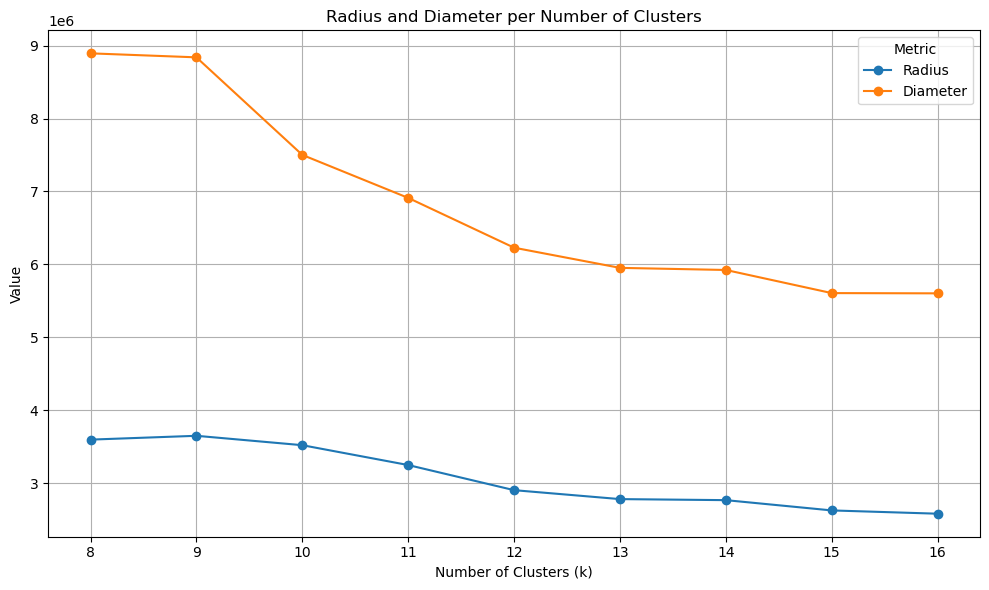

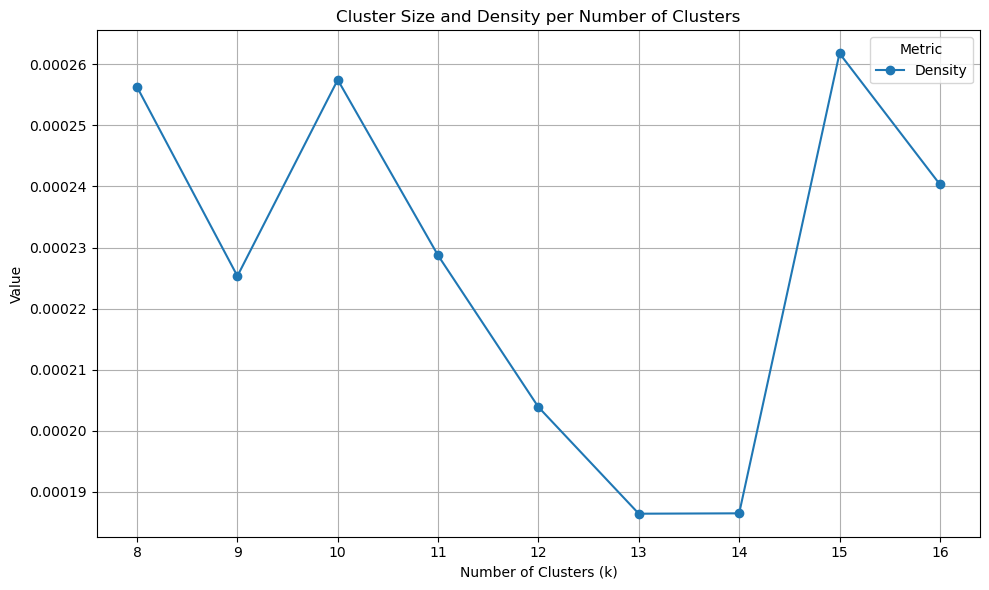

In [14]:
# read the file averageCases_output.txt
def parse_avg_file(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()

    data = []
    k = None
    for line in lines:
        line = line.strip()
        if line.startswith("=== AVERAGES FOR k ="):
            k = int(re.search(r'k\s*=\s*(\d+)', line).group(1))
        elif ':' in line and k is not None:
            metric, value = line.split(':')
            data.append({'k': k, 'Metric': metric.strip(), 'Value': float(value)})

    return pd.DataFrame(data)

# read data and plot
df = parse_avg_file('output/averageCases_output.txt')
averages_df = df.pivot(index='k', columns='Metric', values='Value')

# graph for radius and diameter - the values are extremely high
averages_df[['Radius', 'Diameter']].plot(marker='o', figsize=(10, 6))
plt.title('Radius and Diameter per Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Value')
plt.grid(True)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

# graph for density - values are extremely low
averages_df[['Density']].plot(marker='o', figsize=(10, 6))
plt.title('Cluster Size and Density per Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Value')
plt.grid(True)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

# averages_df = df.pivot(index='k', columns='Metric', values='Value')

# averages_df.plot(marker='o', figsize=(10,6))
# plt.title('Average Metrics by Number of Clusters (k)')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('Value')
# plt.grid(True)
# plt.legend(title='Metric')
# plt.tight_layout()
# plt.show()

We can conclude for this graphs that the best k value is 15, so we should have **15 clusters**.

[8, 9, 10, 11, 12, 13, 14, 15, 16]
[7, 8, 7, 8, 9, 10, 10, 11, 12]


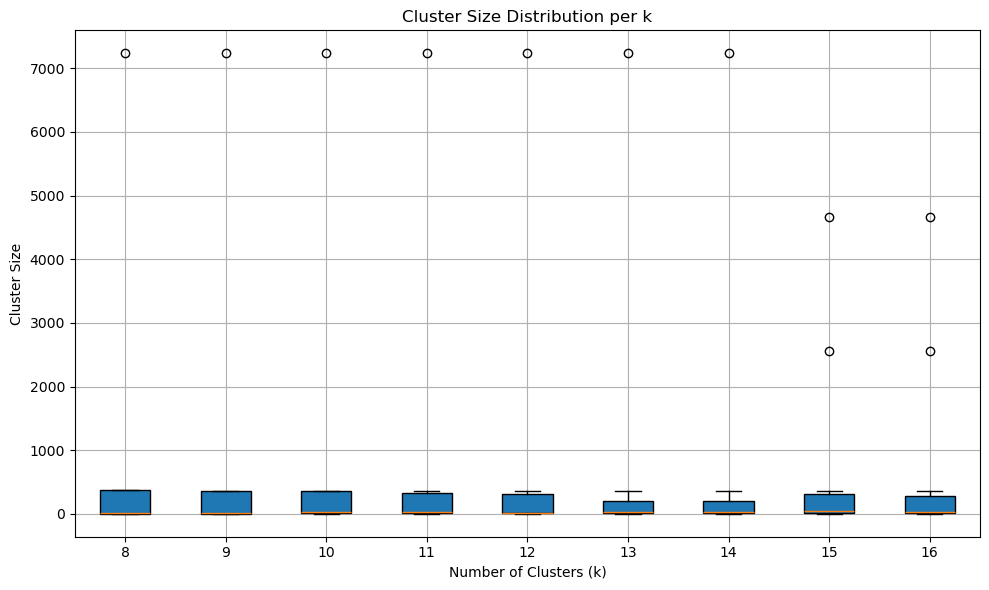

In [15]:
# group sizes by k
cluster_sizes = defaultdict(list)

with open('output/clustering_output.txt', 'r') as f:
    current_k = None
    for line in f:
        line = line.strip()
        match_k = re.match(r'--- Clustering with k = (\d+) ---', line)
        if match_k:
            current_k = int(match_k.group(1))
        elif line.startswith("Size") and current_k is not None:
            size = int(line.split('=')[1].strip())
            cluster_sizes[current_k].append(size)

# data to boxplot
sorted_ks = sorted(cluster_sizes.keys())
size_data = [cluster_sizes[k] for k in sorted_ks]

print(sorted_ks)
print([len(c) for c in size_data])

# create boxplot
plt.figure(figsize=(10,6))
box = plt.boxplot(size_data, patch_artist=True)
plt.title('Cluster Size Distribution per k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cluster Size')
plt.grid(True)

# add the k values as labels to the ticks on the x-axis
plt.xticks(ticks=range(1, len(sorted_ks) + 1), labels=sorted_ks)

plt.tight_layout()
plt.show()

# plt.figure(figsize=(10,6))
# plt.boxplot(size_data, labels=sorted_ks)
# plt.title('Cluster Size Distribution per k')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('Cluster Size')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

Para determinar o melhor valor de k (número de clusters) com base nos três gráficos apresentados, precisamos considerar um equilíbrio entre distribuição balanceada, compacidade dos clusters (raio e diâmetro) e densidade. Vamos analisar:
1. Gráfico de Boxplot (Cluster Size Distribution):

    Mostra que a distribuição começa a ficar desbalanceada a partir de k=13, com clusters muito pequenos e um muito grande (outliers).

    Valores mais equilibrados estão entre k = 8 a 12.

2. Gráfico de Raio e Diâmetro (Compacidade dos Clusters):

    O raio e o diâmetro diminuem com o aumento de k, como esperado.

    Maior queda ocorre até k = 12, depois as melhorias são menores (curva mais plana).

    Isso indica que a partir de k = 13, a melhoria na compacidade é marginal.

3. Gráfico de Densidade:

    A densidade é mais alta para k = 8, 10 e 15.

    No entanto, em k = 15 o boxplot mostra forte desbalanceamento — clusters grandes e pequenos.

    k = 10 apresenta boa densidade e distribuição mais balanceada.

Conclusão: Melhor valor de k

Com base na análise conjunta:

    k = 10 parece ser o valor mais equilibrado.

        Boa densidade (um dos picos).

        Distribuição razoavelmente balanceada (sem grandes outliers).

        Boa redução de raio e diâmetro, antes da curva achatar.

Se quiser, posso te ajudar a fazer uma análise com mais métricas como silhueta ou Davies-Bouldin, se tiveres esses dados.

{8: array([2, 2, 2, ..., 2, 2, 2]), 9: array([2, 2, 2, ..., 2, 2, 2]), 10: array([2, 2, 2, ..., 2, 2, 2]), 11: array([2, 2, 2, ..., 2, 2, 2]), 12: array([2, 2, 2, ..., 2, 2, 2]), 13: array([2, 2, 2, ..., 2, 2, 2]), 14: array([0, 0, 0, ..., 0, 0, 0]), 15: array([6, 6, 0, ..., 0, 0, 6]), 16: array([6, 6, 4, ..., 4, 4, 6])}


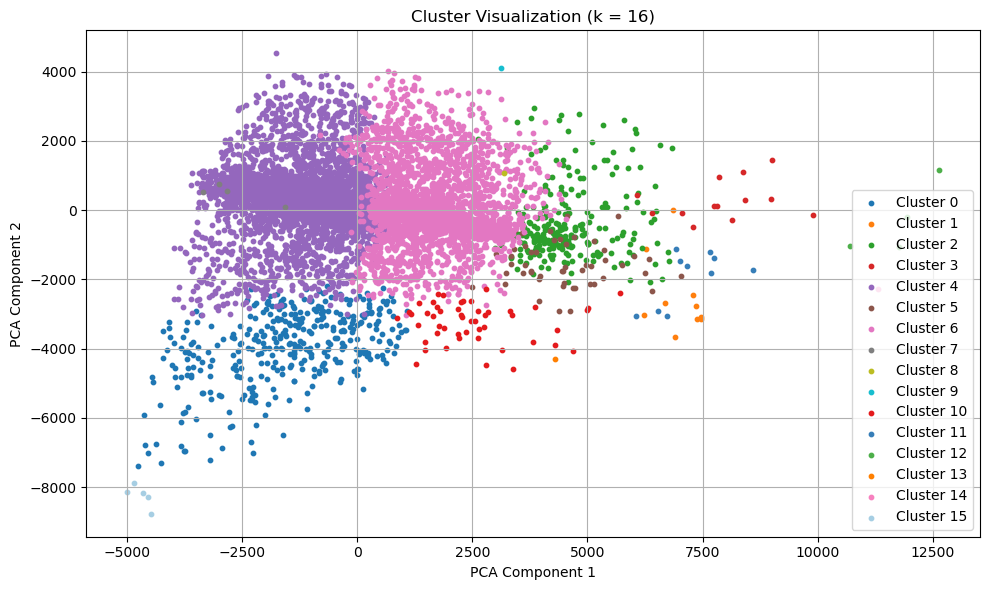

In [16]:
def plot_clusters(data, labels, k):
    """
    Reduz os dados para 2D com PCA e plota os clusters.
    """
    # Certifica-se de que data está em formato NumPy array
    data = np.array(data)

    # Certifica-se de que labels está em formato NumPy array
    labels = np.array(labels)

    # Redução de dimensionalidade para 2D
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data)

    colors = [
        "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", 
        "#e377c2", "#7f7f7f", "#bcbd22", "#17becf", "#e41a1c", "#377eb8", 
        "#4daf4a", "#ff7f00", "#f781bf", "#a6cee3"
    ]

    plt.figure(figsize=(10, 6))
    for cluster_id in range(k):
        cluster_points = reduced_data[labels == cluster_id]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_id}', s=10, color=colors[cluster_id % len(colors)])

    plt.title(f'Cluster Visualization (k = {k})')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

k = 16
print(labels_dict)
labels_k = labels_dict[k]
plot_clusters(small_features, labels_k, k)

In [13]:
import pyspark.sql.functions as F

# sampled = spark_features.sample(fraction=0.1, seed=42)  # pega 10% dos dados
# features_array = sampled.drop("track_id").toPandas().astype(float).values

# batch_size = 20000
# num_rows = spark_features.count()

# batches = []
# for start in range(0, num_rows, batch_size):
#     batch = spark_features.withColumn("row_id", F.monotonically_increasing_id()) \
#                           .filter((F.col("row_id") >= start) & (F.col("row_id") < start + batch_size)) \
#                           .drop("track_id", "row_id") \
#                           .toPandas()
#     batches.append(batch)

# # Junta tudo em NumPy
# import numpy as np
# features_array = np.vstack([df.values.astype(float) for df in batches])

from pyspark.sql.functions import monotonically_increasing_id
import numpy as np

# Passo 1: adiciona um índice fixo (persistido)
indexed_df = spark_features.withColumn("row_id", monotonically_increasing_id())
indexed_df = indexed_df.cache()  # evita reprocessar

# Confirma o número de linhas
num_rows = indexed_df.count()
batch_size = 20000

# Passo 2: divide em batches e converte com segurança
batches = []
for start in range(0, num_rows, batch_size):
    batch = indexed_df.filter((F.col("row_id") >= start) & (F.col("row_id") < start + batch_size)) \
                      .drop("track_id", "row_id") \
                      .toPandas()
    batches.append(batch)

# Passo 3: junta tudo no array final
features_array = np.vstack([df.values.astype(float) for df in batches])

25/04/23 13:50:38 WARN CacheManager: Asked to cache already cached data.
25/04/23 13:51:02 WARN BlockManager: Block rdd_67_4 could not be removed as it was not found on disk or in memory
25/04/23 13:51:02 ERROR Executor: Exception in task 4.0 in stage 18.0 (TID 328)
java.lang.OutOfMemoryError: Java heap space
	at java.base/java.lang.Integer.valueOf(Integer.java:1081)
	at net.razorvine.pickle.Unpickler.load_memoize(Unpickler.java:712)
	at net.razorvine.pickle.Unpickler.dispatch(Unpickler.java:341)
	at net.razorvine.pickle.Unpickler.load(Unpickler.java:109)
	at net.razorvine.pickle.Unpickler.loads(Unpickler.java:122)
	at org.apache.spark.api.python.SerDeUtil$.$anonfun$pythonToJava$2(SerDeUtil.scala:121)
	at org.apache.spark.api.python.SerDeUtil$$$Lambda$2904/0x00007081c4c84d70.apply(Unknown Source)
	at scala.collection.Iterator$$anon$11.nextCur(Iterator.scala:486)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:492)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.sc

Py4JError: An error occurred while calling o187.count

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/home/rafaela/anaconda3/envs/fcd/lib/python3.12/site-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/rafaela/anaconda3/envs/fcd/lib/python3.12/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/rafaela/anaconda3/envs/fcd/lib/python3.12/site-packages/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving


In [ ]:
print(features_array.shape)
print(features_array.shape[0])

(3760, 518)
3760


#### BFR Algorithm

In [8]:
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import mahalanobis

def initialize_ds(data_sample, k):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(data_sample)
    clusters = {}
    for i in range(k):
        points = data_sample[kmeans.labels_ == i]
        clusters[i] = {
            'N': len(points),
            'SUM': np.sum(points, axis=0),
            'SUMSQ': np.sum(points**2, axis=0),
        }
    return clusters

def mahalanobis_dist(point, cluster):
    centroid = cluster['SUM'] / cluster['N']
    variance = (cluster['SUMSQ'] / cluster['N']) - (centroid ** 2)
    variance[variance == 0] = 1e-10  # evitar divisão por zero
    inv_var = 1.0 / variance
    return np.sqrt(np.sum((point - centroid) ** 2 * inv_var))

def process_full_dataset(data, k, batch_size=10000, threshold=2.0):
    DS = {}
    CS = {}
    RS = []

    # Passo 1: inicializar com primeiros batch_size pontos
    initial_sample = data[:batch_size]
    DS = initialize_ds(initial_sample, k)

    # Passo 2 a 6: processar o restante
    for batch_start in range(batch_size, len(data), batch_size):
        batch = data[batch_start:batch_start + batch_size]

        for point in batch:
            assigned = False
            for cid, cluster in DS.items():
                if mahalanobis_dist(point, cluster) < threshold:
                    cluster['N'] += 1
                    cluster['SUM'] += point
                    cluster['SUMSQ'] += point ** 2
                    assigned = True
                    break
            if not assigned:
                RS.append(point)

        # Formar CS se RS tiver pontos suficientes
        if len(RS) > k:
            kmeans = KMeans(n_clusters=k, random_state=42).fit(RS)
            CS.clear()
            new_RS = []

            for i in range(k):
                points = np.array([RS[j] for j in range(len(RS)) if kmeans.labels_[j] == i])
                if len(points) <= 1:
                    new_RS.extend(points)  # volta ao RS
                else:
                    CS[i] = {
                        'N': len(points),
                        'SUM': np.sum(points, axis=0),
                        'SUMSQ': np.sum(points**2, axis=0)
                    }
            RS = new_RS

        # Fundir CS → DS
        merged = []
        for cs_id, cs_cluster in CS.items():
            cs_centroid = cs_cluster['SUM'] / cs_cluster['N']
            for ds_id, ds_cluster in DS.items():
                if mahalanobis_dist(cs_centroid, ds_cluster) < threshold:
                    ds_cluster['N'] += cs_cluster['N']
                    ds_cluster['SUM'] += cs_cluster['SUM']
                    ds_cluster['SUMSQ'] += cs_cluster['SUMSQ']
                    merged.append(cs_id)
                    break
        for cs_id in merged:
            del CS[cs_id]

    return DS, CS, RS

O que esse código cobre:

    ✅ Inicializa clusters com KMeans (passo 1).

    ✅ Processa dados por lotes (passo 2).

    ✅ Atribui a clusters DS ou envia para RS (passo 3).

    ✅ Reagrupa RS em CS (passo 4).

    ✅ Tenta fundir CS e DS (passo 5).

    ✅ Itera até fim (passo 6).

In [9]:
k = 10  # best value of k found
DS, CS, RS = process_full_dataset(features_array, k)